In [8]:
import os, sys
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars

setup_data_vars()

In [9]:
# read in the json file for the totalbinary case

path = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get('TotalBinary'), 'dataset.json')
assert os.path.exists(path)

import json

with open(path, 'r') as f:
    dataset = json.load(f)

In [10]:
ctvn = dataset['labels']['ctvn']
ctvp = dataset['labels']['ctvp']
anorectum = dataset['labels']['anorectum']
vagina = dataset['labels']['vagina']
uterus = dataset['labels']['uterus']

In [11]:
# subset of ids that appear in all 3

overlap = set(set(ctvn) & set(ctvp)).union(set(ctvn) & set(anorectum)).union(set(ctvp) & set(anorectum))
overlap = sorted(list(overlap))
print(overlap)

[9, 10, 19, 29, 30, 34, 35, 36, 37, 38, 39, 40, 44, 54, 55, 56, 64, 65, 66, 67, 68, 69, 70, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [12]:
overlap_frequency = {i: [] for i in overlap}

In [13]:
from itertools import chain, combinations
import json

def powerset(iterable):
    # powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

n_labels = 7

labelscomb = list(powerset(range(1,n_labels + 1)))
multilabels = range(len(labelscomb))
labelscomb_to_multilabel = dict(zip(labelscomb, multilabels))

# So `labelscomb_to_multilabel` is basically a look-up table for converting a combination
# of labels to the huge integer value that will be used in the nnU-Net nifti label file.
labelscomb_to_multilabel

{(): 0,
 (1,): 1,
 (2,): 2,
 (3,): 3,
 (4,): 4,
 (5,): 5,
 (6,): 6,
 (7,): 7,
 (1, 2): 8,
 (1, 3): 9,
 (1, 4): 10,
 (1, 5): 11,
 (1, 6): 12,
 (1, 7): 13,
 (2, 3): 14,
 (2, 4): 15,
 (2, 5): 16,
 (2, 6): 17,
 (2, 7): 18,
 (3, 4): 19,
 (3, 5): 20,
 (3, 6): 21,
 (3, 7): 22,
 (4, 5): 23,
 (4, 6): 24,
 (4, 7): 25,
 (5, 6): 26,
 (5, 7): 27,
 (6, 7): 28,
 (1, 2, 3): 29,
 (1, 2, 4): 30,
 (1, 2, 5): 31,
 (1, 2, 6): 32,
 (1, 2, 7): 33,
 (1, 3, 4): 34,
 (1, 3, 5): 35,
 (1, 3, 6): 36,
 (1, 3, 7): 37,
 (1, 4, 5): 38,
 (1, 4, 6): 39,
 (1, 4, 7): 40,
 (1, 5, 6): 41,
 (1, 5, 7): 42,
 (1, 6, 7): 43,
 (2, 3, 4): 44,
 (2, 3, 5): 45,
 (2, 3, 6): 46,
 (2, 3, 7): 47,
 (2, 4, 5): 48,
 (2, 4, 6): 49,
 (2, 4, 7): 50,
 (2, 5, 6): 51,
 (2, 5, 7): 52,
 (2, 6, 7): 53,
 (3, 4, 5): 54,
 (3, 4, 6): 55,
 (3, 4, 7): 56,
 (3, 5, 6): 57,
 (3, 5, 7): 58,
 (3, 6, 7): 59,
 (4, 5, 6): 60,
 (4, 5, 7): 61,
 (4, 6, 7): 62,
 (5, 6, 7): 63,
 (1, 2, 3, 4): 64,
 (1, 2, 3, 5): 65,
 (1, 2, 3, 6): 66,
 (1, 2, 3, 7): 67,
 (1, 2, 4, 5): 

In [14]:
import numpy as np

def operation(x):
        labels_in_voxel = tuple(np.argwhere(x)[:, 0] + 1)
        return labelscomb_to_multilabel[labels_in_voxel]

def image_to_nnunet_multilabel(input_volume):
    # Note `input_volume` should be one-hot encoded, so input_volume.shape == (n_labels, D, H, W)
    input_volume_per_channel = input_volume.reshape(n_labels, -1).T # (D x H x W, n_labels)
    print('starting operation')
    input_volume_translated = np.apply_along_axis(operation, 1, input_volume_per_channel)
    print('done operation')
    correct_shape = input_volume_translated.reshape(input_volume.shape[1:]) # (D, H, W)
    
    return correct_shape

In [15]:
# read in the ground truth labels for the totalbinary case and select the frequency of each id

# maybe do with original trainer?
# don't forget to do with total segmentator also

# path = os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres')
# labels = sorted([f for f in os.listdir(path) if f.endswith('.npz')])

path = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get('TotalBinary'), os.environ.get('data_trainingLabels'))
labels = sorted([f for f in os.listdir(path) if f.endswith('.nii.gz')])

import SimpleITK as sitk
import numpy as np

from tqdm import tqdm

for label in tqdm(labels):
    label_path = os.path.join(path, label)
    
    img = sitk.GetArrayFromImage(sitk.ReadImage(label_path))
    
    # count the number of non zero elements
    number_of_voxels = np.count_nonzero(img)

    for i in overlap:
        overlap_frequency[i].append((np.sum(img == i), number_of_voxels))

100%|██████████| 100/100 [08:47<00:00,  5.28s/it]


In [16]:
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [17]:
import json

# dump the overlap_frequency to a json file
with open('overlap_frequency_nnunet_groundtruth.json', 'w') as f:
    json.dump(overlap_frequency, f, cls=NpEncoder)

In [18]:
print(overlap_frequency[9])

[(0, 583890), (0, 455905), (0, 479810), (3241, 630386), (0, 405020), (5, 294437), (0, 408080), (93, 364963), (48, 469751), (0, 207840), (79, 259923), (490, 305021), (2459, 453443), (0, 391020), (8, 484746), (0, 271845), (163, 408364), (0, 521078), (0, 312132), (148, 452864), (129, 312991), (0, 506284), (47, 539553), (65, 425014), (0, 577315), (1005, 479499), (0, 646780), (309, 381831), (0, 522833), (5, 476692), (0, 317862), (0, 323841), (1, 467657), (293, 590632), (0, 299607), (4, 503585), (0, 578694), (79, 540425), (0, 479217), (217, 662235), (0, 591459), (0, 261903), (0, 623731), (0, 607635), (0, 308636), (19, 678735), (13, 534811), (0, 436119), (0, 586136), (5, 492819), (0, 419814), (0, 360247), (0, 346517), (0, 310735), (17, 146801), (0, 669126), (0, 380416), (101, 407699), (4269, 756176), (772, 579204), (0, 354279), (28, 542770), (0, 476460), (0, 353326), (0, 366271), (123, 410798), (0, 547301), (983, 757915), (49, 490454), (0, 704832), (74, 624926), (3, 347569), (36, 273535), (0,

In [19]:
number_of_ocurrences = {i: sum([j[0] for j in overlap_frequency[i]]) for i in overlap}
percentage_of_ocurrences = {i: 0 for i in overlap}

for i in overlap:
    percentage_of_ocurrences[i] = number_of_ocurrences[i] / sum([j[1] for j in overlap_frequency[i]])

In [20]:
percentage_of_ocurrences

{9: 0.0003440026115071675,
 10: 2.0145336853954786e-05,
 19: 1.8886253300582612e-07,
 29: 0.0,
 30: 0.0,
 34: 0.0,
 35: 1.95157950772687e-06,
 36: 0.0,
 37: 0.0,
 38: 1.9096100559477973e-06,
 39: 2.4531144564867858e-05,
 40: 3.1686936093199716e-06,
 44: 0.0,
 54: 9.275248843175016e-06,
 55: 0.0016889766479452133,
 56: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 1.1121904721454204e-06,
 81: 2.056503137174551e-06,
 82: 0.0,
 84: 0.0,
 85: 2.0984725889536234e-08,
 86: 0.0,
 94: 0.001245779237158208,
 95: 4.742548051035189e-06,
 96: 0.0,
 99: 0.0,
 100: 0.0,
 101: 0.0,
 102: 0.0,
 103: 0.0,
 104: 0.0,
 105: 0.0,
 106: 0.0,
 107: 0.0,
 109: 0.0,
 110: 0.0,
 111: 0.0,
 112: 0.0,
 113: 0.0,
 114: 0.0,
 115: 0.0,
 116: 0.0,
 119: 0.0,
 120: 0.0,
 121: 0.0,
 122: 0.0,
 123: 0.0,
 124: 0.0,
 125: 0.0,
 126: 0.0,
 127: 0.0}

In [21]:
non_zero_ocurrences = {k: v for (k,v) in number_of_ocurrences.items() if v != 0}
non_zero_ocurrences

{9: 16393,
 10: 960,
 19: 9,
 35: 93,
 38: 91,
 39: 1169,
 40: 151,
 54: 442,
 55: 80486,
 80: 53,
 81: 98,
 85: 1,
 94: 59366,
 95: 226}

In [22]:
# translated to the combo of words

def reverse_lookup_id(id):
    # given a dictinoary of key: anatomy, and value: segmentation ids, reverse the lookup to get the list of anatomies that match the id.
    anatomies = []

    if type(id) == int:
        for k, v in dataset['labels'].items():
            if k == 'background':
                if id == v:
                    anatomies.append('background')
            elif id in v:
                anatomies.append(k)
            
    elif type(id) == list:
        for k, v in dataset['labels'].items():
            if k == 'background' and 0 in id:
                anatomies.append('background')
            elif any([i in v for i in id]):
                anatomies.append(k)
    else:
        raise TypeError('Huh? Whats the type of id? needs to be int or list of ints ', id)

    return anatomies

assert reverse_lookup_id(0) == ['background']
assert reverse_lookup_id(1) == ['anorectum']
assert reverse_lookup_id(100) == ['anorectum', 'bladder', 'ctvn', 'ctvp', 'uterus']
assert reverse_lookup_id([0,1]) == ['background', 'anorectum']

def get_id_from_label(str_id):
    return ['anorectum','bladder','ctvn','ctvp','parametrium','uterus','vagina','totalbinary'][str_id]

assert get_id_from_label(0) == 'anorectum'
assert get_id_from_label(7) == 'totalbinary'

In [23]:
type_of_overlap_non_zero = []
frequency_of_overlap_non_zero = []
percentage_of_overlap_non_zero = []

for k,v in non_zero_ocurrences.items():
    type_of_overlap_non_zero.append(', '.join(reverse_lookup_id(k)))
    frequency_of_overlap_non_zero.append(v)
    percentage_of_overlap_non_zero.append(percentage_of_ocurrences[k])

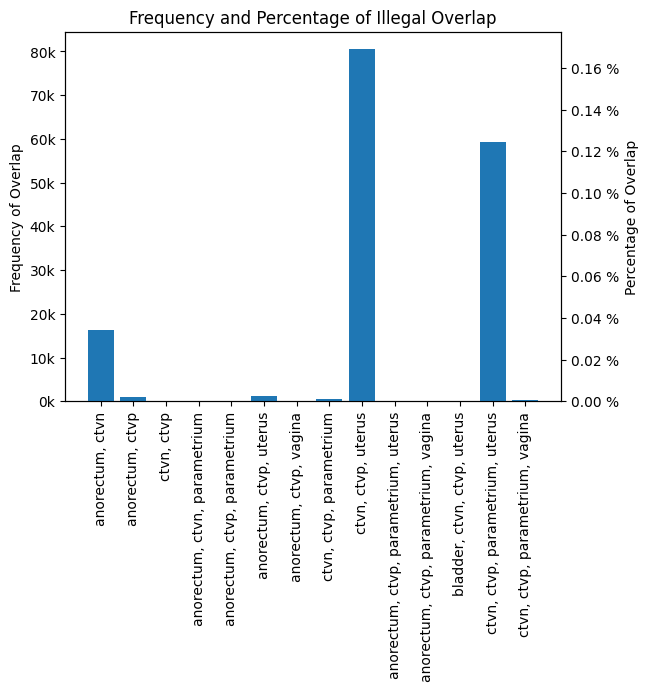

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots()

# Plot the frequency of overlap on the primary y-axis (left-hand side)
ax1.bar(type_of_overlap_non_zero, frequency_of_overlap_non_zero, )
ax1.set_ylabel('Frequency of Overlap')
ax1.tick_params(axis='x', rotation=90)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))

# Create a secondary y-axis (right-hand side) that shares the same x-axis
ax2 = ax1.twinx()
ax2.bar(type_of_overlap_non_zero, percentage_of_overlap_non_zero)
ax2.set_ylabel('Percentage of Overlap')
ax2.tick_params(axis='y')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 100:.2f} %'))

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.title('Frequency and Percentage of Illegal Overlap')

# Display the plot
plt.show()

In [34]:
# read in the frequency for a type of overlap

type_of_model = 'cervical'

with open(f'overlap_frequency_nnunet_{type_of_model}.json', 'r') as f:
    overlap_frequency_nnunet = json.load(f)
number_of_ocurrences_nnunet = {i: sum([j[0] for j in overlap_frequency_nnunet[str(i)]]) for i in overlap}
non_zero_ocurrences_nnunet = {k: v for (k,v) in number_of_ocurrences_nnunet.items() if v != 0}

with open(f'overlap_frequency_totalsegmentator_{type_of_model}.json', 'r') as f:
    overlap_frequency_totalsegmentator = json.load(f)
number_of_ocurrences_totalsegmentator = {i: sum([j[0] for j in overlap_frequency_totalsegmentator[str(i)]]) for i in overlap}
non_zero_ocurrences_totalsegmentator = {k: v for (k,v) in number_of_ocurrences_totalsegmentator.items() if v != 0}

In [35]:
non_zero_ocurrences_nnunet

{9: 3022, 19: 989, 54: 4, 55: 63532, 94: 45337}

In [36]:
non_zero_ocurrences_totalsegmentator

{9: 3022, 19: 989, 54: 4, 55: 63532, 94: 45337}

In [37]:
non_zero_ocurrences

{9: 16393,
 10: 960,
 19: 9,
 35: 93,
 38: 91,
 39: 1169,
 40: 151,
 54: 442,
 55: 80486,
 80: 53,
 81: 98,
 85: 1,
 94: 59366,
 95: 226}

In [38]:
set_of_non_zeros = set(non_zero_ocurrences.keys()).union(set(non_zero_ocurrences_nnunet.keys())).union(set(non_zero_ocurrences_totalsegmentator.keys()))
set_of_non_zeros

{9, 10, 19, 35, 38, 39, 40, 54, 55, 80, 81, 85, 94, 95}

In [39]:
# if the key doesn't exist, then the value is 0
non_zero_ocurrences = {i: non_zero_ocurrences.get(i, 0) for i in set_of_non_zeros}
non_zero_ocurrences_nnunet = {i: non_zero_ocurrences_nnunet.get(i, 0) for i in set_of_non_zeros}
non_zero_ocurrences_totalsegmentator = {i: non_zero_ocurrences_totalsegmentator.get(i, 0) for i in set_of_non_zeros}

In [42]:
type_of_overlap_non_zero = []
frequency_of_overlap_non_zero = []
frequency_of_overlap_non_zero_nnunet = []
frequency_of_overlap_non_zero_totalsegmentator = []
percentage_of_overlap_non_zero = []

for k,v in non_zero_ocurrences.items():
    type_of_overlap_non_zero.append(', '.join(reverse_lookup_id(k)))
    frequency_of_overlap_non_zero.append(v)
    frequency_of_overlap_non_zero_nnunet.append(non_zero_ocurrences_nnunet[k])
    frequency_of_overlap_non_zero_totalsegmentator.append(non_zero_ocurrences_totalsegmentator[k])
    
    percentage_of_overlap_non_zero.append(percentage_of_ocurrences[k])

In [41]:
# Plot the values together

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots()

# Plot the frequency of overlap on the primary y-axis (left-hand side)
ax1.bar(type_of_overlap_non_zero, frequency_of_overlap_non_zero, label='Ground Truth')
ax1.bar(type_of_overlap_non_zero, )
ax1.set_ylabel('Frequency of Overlap')
ax1.tick_params(axis='x', rotation=90)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))

# Create a secondary y-axis (right-hand side) that shares the same x-axis
ax2 = ax1.twinx()
ax2.bar(type_of_overlap_non_zero, percentage_of_overlap_non_zero)
ax2.set_ylabel('Percentage of Overlap')
ax2.tick_params(axis='y')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 100:.2f} %'))

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.title('Frequency and Percentage of Illegal Overlap')

# Display the plot
plt.show()